# Sign Language digit classifier

This notebook guides through the process of classifying sign language digits. It utilises a Convolutional Neural Network architecture built with Keras library. The purpose of this notebook is to showcase an examplary workflow when dealing with simple computer-vision based tasks.

## Introduction

In [243]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

RAND_SEED = 7
DATA_PATH = "data/data.npy"
LABELS_PATH = "data/labels.npy"

In [244]:
BATCH_SIZE = 96, 
EPOCHS = 50, 
VAL_SPLIT=0.2,
LEARNING_RATE = 0.0002, 
DECAY = 1e-6

Let's load in our data and explore it a little bit.

In [245]:
X = np.load(DATA_PATH)
y = np.load(LABELS_PATH)

X.shape, y.shape

((2062, 64, 64), (2062, 10))

There are 2062 images in our dataset, each the size of 64x64 pixels. Every image has a corresponding label; there are 10 different classes in our data, making it a multiclass (multinominal) classification problem.

For now, our dataset looks like this:

In [246]:
X[0], y[0]

(array([[0.47450978, 0.46274507, 0.45098037, ..., 0.50196075, 0.5137255 ,
         0.52549016],
        [0.46666664, 0.45098037, 0.43921566, ..., 0.4980392 , 0.5098039 ,
         0.52156866],
        [0.45490193, 0.43921566, 0.42745095, ..., 0.49411762, 0.50196075,
         0.517647  ],
        ...,
        [0.4470588 , 0.4352941 , 0.4235294 , ..., 0.49019605, 0.4980392 ,
         0.5058824 ],
        [0.45490193, 0.44313723, 0.43137252, ..., 0.4980392 , 0.5058824 ,
         0.5137255 ],
        [0.46274507, 0.45098037, 0.43921566, ..., 0.50196075, 0.5098039 ,
         0.52156866]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

Looks like our images are already normalised (values between 0 and 1) but the labels are one-hot-encoded.

Let's check out the class distribution in our dataset.

In [247]:
unique, count = np.unique(np.argmax(y, axis=1), return_counts=True)
occurences = dict(zip(unique, count))
print(f"The number of occurences of each class in the dataset = {occurences}")

The number of occurences of each class in the dataset = {0: 205, 1: 206, 2: 206, 3: 206, 4: 207, 5: 207, 6: 207, 7: 206, 8: 208, 9: 204}


So far, so good; all the classes in our dataset are evenly distributed.

## Data visualisation

Let's prepare some visualisations to better understand our data, we'll start with a random sample of our dataset. Since we'll randomly reorder our data a couple of times, we can write a function for that aswell.

In [248]:
def shuffle_data(image_data, label_data, random_seed):
    return np.random.RandomState(random_seed).permutation(image_data), np.random.RandomState(random_seed).permutation(label_data)

def display_rand_imgs(image_data, label_data, random_seed):
    images, labels = shuffle_data(image_data, label_data, random_seed)
    
    fig, axes = plt.subplots(5, 5, figsize = (15,15))
    plt.suptitle("Random images and their labels", fontsize=18)
    for row in axes:
        for axis in row:
            index = np.random.randint(random_seed)
            image = images[index].reshape(64, 64)
            label = np.argmax(labels[index])
            axis.imshow(image, cmap='binary')
            axis.set_title(f"Number {label}")
            axis.set_axis_off()        

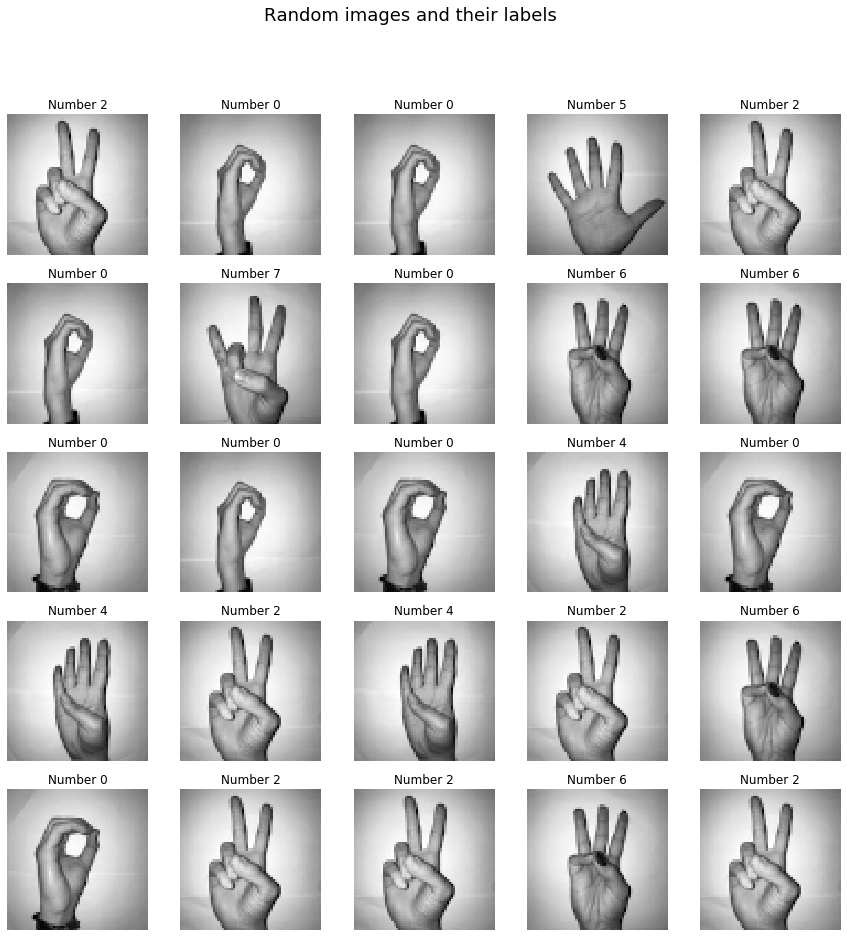

In [249]:
display_rand_imgs(X, y, RAND_SEED)

An interesting thing would be to plot the mean of every class and see whether they are (on average) different enough for our neural network to pick differences

In [92]:
count

array([205, 206, 206, 206, 207, 207, 207, 206, 208, 204], dtype=int64)

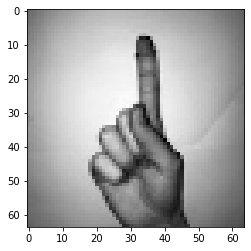

In [97]:
plt.imshow(X[205].reshape(64,64), cmap="binary")

In [130]:
current_count=0
for img_class in range(len(unique)):
    current_count += count[img_class]  
    print(current_count)

205
411
617
823
1030
1237
1444
1650
1858
2062


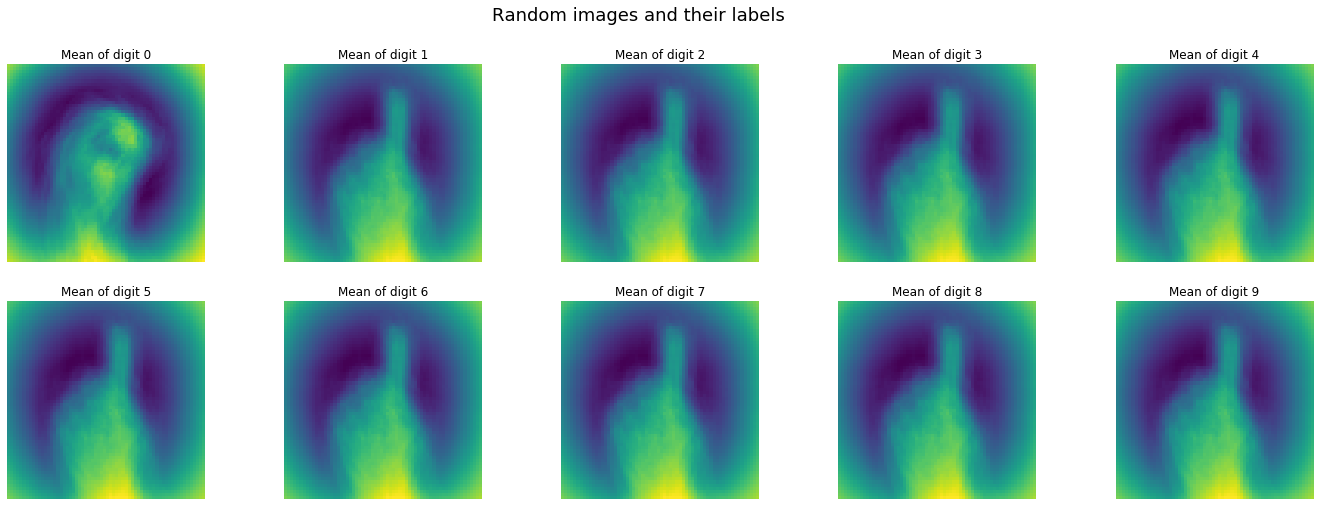

In [124]:
#reusing our old variables unique(every unique class) and count(number of occurences for each class)
plt.figure(figsize=(24,8))
plt.suptitle("Random images and their labels", fontsize=18)

for img_class in range(len(unique)):

    if img_class == 0:
        x_num = X[0: count[img_class]]
        mean_num = x_num.mean(axis=0)
    else:
        x_range_start = count[img_class-1]  
        x_range_end = count[img_class-1] + count[img_class]
        x_num = X[x_range_start:x_range_end] 
        mean_num = x_num.mean(axis=0) 
        
#     print(len(x_num))
#     print(x_num)
    plt.subplot(2,5,img_class+1)
    plt.title(f"Mean of digit {img_class}")
    plt.imshow(mean_num)
    plt.axis("off")
    

In [ ]:
#reusing our old variables unique(every unique class) and count(number of occurences for each class)
plt.figure(figsize=(24,8))
plt.suptitle("Random images and their labels", fontsize=18)

for img_class in range(len(unique)):
    x_num = X[0: count[img_class]]
    
        
    print(len(x_num))
    mean_num = x_num.mean(axis=0)

    plt.subplot(2,5,img_class+1)
    plt.title(f"Mean of digit {img_class}")
    plt.imshow(mean_num)
    plt.axis("off")
    

We can clearly see that there are some distinct features for every sign (every image class) which is good, since our neural network will be easily able to differentiate between them. Some misclassifications might happen between digits 6 through 8, because they are very similiar. 

## Data preprocessing

In general, when dealing with images, the data preprocessing workflow consists of:
- randomly reordering data within the dataset
- splitting the data into train and test sets (and sometimes a validation set)
- reshaping the images
- pixel value normalisation
- one-hot encoding

Let's start with first two steps. Since scikit already has a good method for doing both at once, we'll use that. We can also use our own method, since it's always better to shuffle the data multiple times than not to shuffle it at all.

In [250]:
X, y = shuffle_data(X, y, rand_seed+10)

Let's see the randomised data

In [251]:
np.argmax(y[:10], axis=1)

array([3, 6, 3, 3, 0, 7, 5, 5, 0, 8], dtype=int64)

Time to split the data; we'll also check data shape.

In [252]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rand_seed)

In [253]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1649, 64, 64), (413, 64, 64), (1649, 10), (413, 10))

In [269]:
x_train[0]

array([[0.517647  , 0.5058824 , 0.49411762, ..., 0.56078434, 0.572549  ,
        0.58431375],
       [0.5058824 , 0.49411762, 0.4823529 , ..., 0.5568627 , 0.5686275 ,
        0.5764706 ],
       [0.49411762, 0.4823529 , 0.4705882 , ..., 0.54509807, 0.5568627 ,
        0.5686275 ],
       ...,
       [0.48627448, 0.47450978, 0.46666664, ..., 0.5490196 , 0.5568627 ,
        0.5686275 ],
       [0.4980392 , 0.4823529 , 0.4705882 , ..., 0.5529412 , 0.56470585,
        0.572549  ],
       [0.5058824 , 0.4980392 , 0.48627448, ..., 0.56078434, 0.5686275 ,
        0.5803921 ]], dtype=float32)

Now we have to reshape the data to feed it into our neural network. In addition to our image shape, we also need to specify one extra dimension for Keras library for the color channels. 

Since we operate on greyscale images, we will add 1 as the last dimension. In case of color images, we would add 3 as the channel (for Red, Green and Blue).

In [270]:
x_train = x_train.reshape(x_train.shape[0], 64, 64, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 64, 64, 1).astype('float32')

In [271]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1649, 64, 64, 1), (413, 64, 64, 1), (1649, 10), (413, 10))

In [272]:
x_train[0]

array([[[0.517647  ],
        [0.5058824 ],
        [0.49411762],
        ...,
        [0.56078434],
        [0.572549  ],
        [0.58431375]],

       [[0.5058824 ],
        [0.49411762],
        [0.4823529 ],
        ...,
        [0.5568627 ],
        [0.5686275 ],
        [0.5764706 ]],

       [[0.49411762],
        [0.4823529 ],
        [0.4705882 ],
        ...,
        [0.54509807],
        [0.5568627 ],
        [0.5686275 ]],

       ...,

       [[0.48627448],
        [0.47450978],
        [0.46666664],
        ...,
        [0.5490196 ],
        [0.5568627 ],
        [0.5686275 ]],

       [[0.4980392 ],
        [0.4823529 ],
        [0.4705882 ],
        ...,
        [0.5529412 ],
        [0.56470585],
        [0.572549  ]],

       [[0.5058824 ],
        [0.4980392 ],
        [0.48627448],
        ...,
        [0.56078434],
        [0.5686275 ],
        [0.5803921 ]]], dtype=float32)

At this point, we would usually normalise our images for the values to range between 0 and 1 for each pixel, but with this dataset, it has already been done for us, but we can double check.

In [273]:
print(f"Our values before normalisation \n {x_train[0]*255} \nand after normalisation \n {x_train[0]}")

Our values before normalisation 
 [[[131.99998]
  [129.     ]
  [125.99999]
  ...
  [143.     ]
  [145.99998]
  [149.     ]]

 [[129.     ]
  [125.99999]
  [122.99999]
  ...
  [141.99998]
  [145.     ]
  [147.     ]]

 [[125.99999]
  [122.99999]
  [119.99999]
  ...
  [139.     ]
  [141.99998]
  [145.     ]]

 ...

 [[123.99999]
  [120.99999]
  [118.99999]
  ...
  [139.99998]
  [141.99998]
  [145.     ]]

 [[126.99999]
  [122.99999]
  [119.99999]
  ...
  [141.     ]
  [143.99998]
  [145.99998]]

 [[129.     ]
  [126.99999]
  [123.99999]
  ...
  [143.     ]
  [145.     ]
  [147.99998]]] 
and after normalisation 
 [[[0.517647  ]
  [0.5058824 ]
  [0.49411762]
  ...
  [0.56078434]
  [0.572549  ]
  [0.58431375]]

 [[0.5058824 ]
  [0.49411762]
  [0.4823529 ]
  ...
  [0.5568627 ]
  [0.5686275 ]
  [0.5764706 ]]

 [[0.49411762]
  [0.4823529 ]
  [0.4705882 ]
  ...
  [0.54509807]
  [0.5568627 ]
  [0.5686275 ]]

 ...

 [[0.48627448]
  [0.47450978]
  [0.46666664]
  ...
  [0.5490196 ]
  [0.5568627 ]


Values are divided by 255 in order to normalise them since each pixel is represented as a value between 0 and 255 - it describes pixel's color intensity.

Last step in data preprocessing is to one-hot encode the labels for our images - like with normalisation, it had already been done by the dataset owner.

In [274]:
print(f"Label value for 1st(0th) element before one-hot encoding \n {np.argmax(y_train[0])} \nand after one-hot encoding \n {y_train[0]}")

Label value for 1st(0th) element before one-hot encoding 
 4 
and after one-hot encoding 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


We can see how the 4th (starting from 0) value has a 1 and all the other values are 0 and it matches our decoded value.

## Building our model

Now, it's time to build our Convolutional Neural Network.

In [210]:
def build_cnn_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=x_train.shape[1:]))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation("relu"))

    model.add(Dense(10))
    model.add(Activation("softmax")) 
    
    return model

In [211]:
def perform_data_augmentation():
    datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(x_train)

In [221]:
def compile_model(model, learning_rate, decay):
    opt = keras.optimizers.Adam(lr=0.0002, decay=1e-6)

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

In [222]:
# build_cnn_model()

perform_data_augmentation()

compile_model(build_cnn_model(), LEARNING_RATE, DECAY)

In [234]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(10))
model.add(Activation("softmax")) 

In [235]:
opt = keras.optimizers.Adam(lr=0.0002, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training a Convolutional Neural Network

In [224]:
def train_model(model, data, labels, batch_size, epochs, validation_split, data_augmentation=False):
    if data_augmentation == False:
        hist = model.fit(x_train, y_train, batch_size=96, epochs=50, validation_split=0.2)
    elif data_augmentation == True:
        hist = model.fit_generator(datagen.flow(x_train,y_train, batch_size=128), epochs = 50, 
                                   validation_split = 0.2, verbose = 1, steps_per_epoch=30)

In [230]:
# train_model(build_cnn_model(), x_train, y_train, BATCH_SIZE, EPOCHS, VAL_SPLIT)

In [236]:
hist = model.fit(x_train, y_train, batch_size=96, epochs=50, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1319 samples, validate on 330 samples
Epoch 1/50
1319/1319 [==============================] - 7s 5ms/step - loss: 2.0357 - acc: 0.2881 - val_loss: 1.6811 - val_acc: 0.4606
Epoch 2/50
1319/1319 [==============================] - 4s 3ms/step - loss: 1.3265 - acc: 0.5845 - val_loss: 1.1979 - val_acc: 0.7182
Epoch 3/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.9412 - acc: 0.7202 - val_loss: 0.9197 - val_acc: 0.7667
Epoch 4/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.7278 - acc: 0.7839 - val_loss: 0.7875 - val_acc: 0.7727
Epoch 5/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.6221 - acc: 0.8044 - val_loss: 0.6992 - val_acc: 0.8061
Epoch 6/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.5296 - acc: 0.8324 - val_loss: 0.6744 - val_acc: 0.7909
Epoch 7/50
1319/1319 [==============================] - 4s 3ms/step - loss: 0.4897 - acc: 0.8469 - va

## Evaluating the model

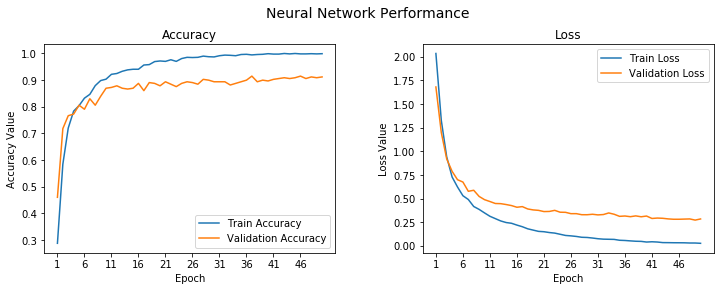

In [278]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = figure.suptitle('Neural Network Performance', fontsize=14)
figure.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 51))
ax1.plot(epoch_list, hist.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [238]:
val_loss, val_acc = model.evaluate(x_test, y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

413/413 [==============================] - 0s 832us/step
Test loss: 0.34906931196228935
Test accuracy: 0.8740920086749818


Predicted digit: 6, actual digit:


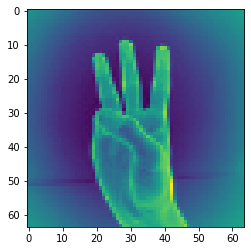

In [280]:
prediction = model.predict(x_test)
print("Predicted digit: {}, actual digit:".format(np.argmax(prediction[9])))
plt.imshow(x_test[9].reshape(64,64))
plt.show()
# plt.imshow(x_test[70], cmap=plt.cm.binary)
# plt.show()

Text(0.5, 51.0, 'Predicted labels')

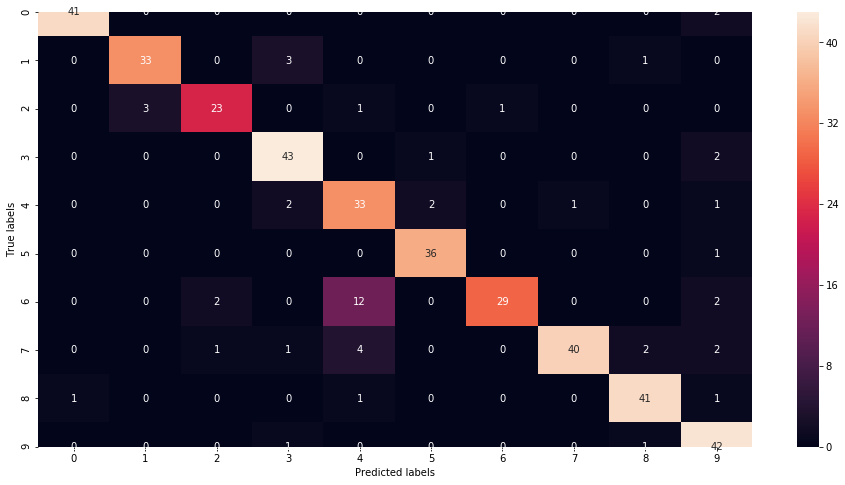

In [292]:
predicted_labels = np.argmax(prediction, axis=1)
test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(16,8))
sns.heatmap(cm,annot=True)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')

## Visualising predictions

## Conclusions